# Image-Based Structural Analysis
### Code created and maintained by Justin David Q. SAN JUAN, <br>email: jdqsj1997@yahoo.com, <br> personal website: justinsj.weebly.com

#### This code focuses in the segmentation and classification processes (except reconstruction) of the complete project pipeline as described below:
<img src="https://justinsj.weebly.com/uploads/6/4/9/2/64923303/process-flowchart_orig.jpg" alt="Drawing" style="width: 800px;"/>

# Import Dependencies
#### Dependencies:
numpy: for handling data types (mostly handled as numpy arrays)<br>
Sequential (from keras.models): for CNN setup<br>
random: for pseudo-random shuffling of data<br>
cv2: for raw RBG image import and transformation to grayscale<br>
time: for measuring time elapsed per function<br>
##### Custom Classes:
ComponentSegmentation: for proposing regions of interest (RoI's)<br>
ExtractionPreprocessing: for trimming, noise removal, and resizing of image<br>
ComponentClassifierTraining: for loading the CNN model, training data, and training the model<br>
ComponentClassifierPredict: for using the CNN model to predict the class of preprocessed extractions<br>
ExtractionLabelling: for labelling ground truth bounding boxes and classes in problem images<br>
TestingClass: for testing the accuracy of a CNN model on the problem images<br>
<br>
print_image_bw is used to print a simple 2-D array<br>
gc: for clearing up space after acquiring data from larger datasets

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

from __future__ import print_function
import numpy as np

from keras.models import Sequential

import random

import cv2
import time

from component_segmentation import ComponentSegmentation
from extraction_preprocessing import ExtractionPreprocessing
from component_classifier_training import ComponentClassifierTraining

from image_preprocessing import ImagePreprocessing
from extraction_labelling import ExtractionLabelling
from testing_class import TestingClass
from helper_functions import print_image_bw

from helper_functions import print_time_string, store_time

import gc
gc.enable()

print('Done Importing...')

c:\users\jdqsj\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Done Importing...


# Hyper-parameters
#### Selective Search Parameters:
scale_input<br>
sigma_input<br>
min_size_input<br>
#### Noise Reduction Parameters:
min_shape: for minimum number of black pixels in bounding box<br>
min_height: for minimum height of bounding box<br>
min_width: for minimum width of bounding box<br>
<br>
buffer_zone: for expanding bounding box all directions<br>
min_area: for minimum area of bounding box<br>
min_black: for minimum number of black pixels in bounding box<br>
min_black_ratio: for minimum ratio of black pixels to the bounding box area<br>
#### Overlap Parameters:
overlap_repeats: for number of iterations for merging algorithm to be applied<br>
overlap_threshold: threshold of area overlap over union area for merging to be applied<br>
#### Removing Unconnected Pieces Parameters:
max_piece_percent: maximum percentage of piece to be removed<br>
(if percentage is larger, piece will not be removed as it is more likely an important piece)<br>
#### Extractions Preprocessing Parameters:
img_rows, img_cols: for classifier input shape<br>
wanted_w, wanted_h: for black pixels edges resizing boundary shape<br>
export_w, export_h: for overall image resizing shape ([export_w-wanted_w]/2 = horizontal buffer on each side)<br>
#### CNN Training Parameters:
num_classes: number of classes for classifier to predict<br>
TRAINING_RATIO_TRAIN: ratio of training samples to total number of samples<br>
TRAINING_RATIO_VAL: ratio of validation samples to total number of samples<br>
TRAINING_RATIO_TEST: ratio of test samples to total number of samples <br>
Note: TRAINING_RATIO_TEST is implicitly calculated as [1-{TRAINING_RATIO_TRAIN + TRAINING_RATIO_VAL}]<br>
dropout: dropout value to be used in all layers except last layer of Sketch-A-Net CNN model<br>
#### CNN Prediction Parameters:
min_percent_match: minimum probability of class prediction for that class to be set as the prediction<br>
min_confidence: minimum difference between first-highest % match and second-highest % match<br>
(higher difference means less ambiguity between first and second highest match, which means less likelihood of random object)<br>
##### The directory is also defined in the PATH variable.<br>The name of the CNN model data is defined in the name variable.<br>The training data set name for the CNN is defined in the data_set_name variable.

In [2]:
#selective search parameters
scale_input=200 #200 previous: #10
sigma_input=10 #10 previous: #15
min_size_input=10 #10 previous: #5

#noise reduction parameters
min_shape=40 #min. number of black pixels  
min_height=5 #min. height of bounding box
min_width=5 #min. width of bounding box

buffer_zone=2 #expand bounding box by this amount in all directions  
min_area=60 #min. area of bounding box
min_black=200 #min. number of black pixels
min_black_ratio=0.01 #min ratio of black pixels to the bounding box area

#Overlap parameters
overlap_repeats = 2 #set to 8
overlap_threshold = 0.3 #set to 0.3 (overlap has to be larger than the threshold)

#Removing unconnected pieces parameters
max_piece_percent=0.3  # set to 0.3

#Extractions preprocessing paramaters
img_rows, img_cols = 100,100
wanted_w, wanted_h, export_w, export_h = img_cols, img_rows, img_cols, img_rows

#CNN training parameters
num_classes = 64
TRAINING_RATIO_TRAIN = 0.7
TRAINING_RATIO_VAL = 0.15
dropout = 0

#CNN prediction parameters
min_percent_match = 0.7 # set to 0.7
min_confidence = 0.3 # set to 0.3

#Time Cost parameters
time_cost_string_list = ['Loading image','Component Segmentation','Extraction Preprocessing',
                         'Component Classifier Training','Component Classifier Predict',
                        'Printing Results','Acquiring and Printing Ground Truth Data',
                        'Data Concatenation & Cleaning','Data Control, Counting, & Training from Multiple Files',
                        'Testing','Printing Confusion Matrix']
time_cost_time_list = np.zeros(len(time_cost_string_list)).astype(np.int).tolist()

#Paths and names
PATH = 'C:/Users/jdqsj/Desktop/Workspace/isa-python/' #must have "/" at the end

model_name = 'Sketch-A-Net_controlled_600_30858_7_layers'

base_dataset_name = 'Training_Samples_64_classes_100x100_all'

dataset_PATH = 'C:/Users/jdqsj/Desktop/Workspace/isa-python/'
dataset_name = 'Training_Samples_64_classes_100x100_all_cleaned_32898'
new_dataset_name = 'Training_Samples_64_classes_100x100_all_cleaned_32898'

print('Done setting hyperparamters...')
%memit

Done setting hyperparamters...
peak memory: 205.06 MiB, increment: 0.04 MiB


# Load Image
Image (binary, grayscale, 2D, numpy array) for regions of interest proposals is loaded.

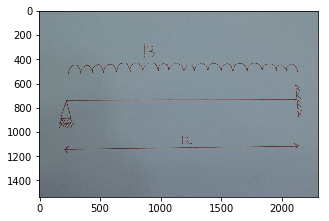

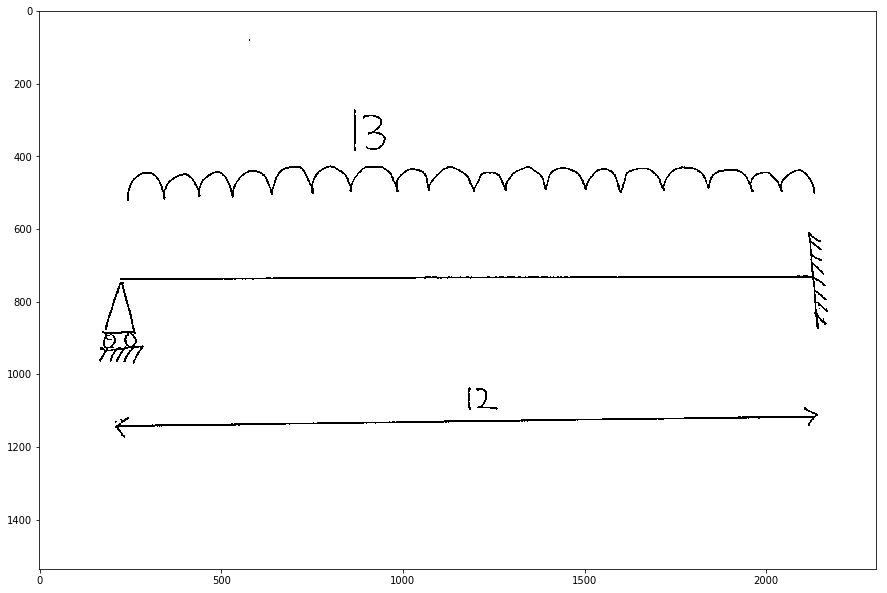

Loading image done... Time Elapsed : 0.7729694843292236 seconds...
peak memory: 227.01 MiB, increment: 0.00 MiB


In [3]:
start = time.time() # Begin time measurement
image_name = 'Q0044V0004S7.JPG'
test_path = 'C:/Users/jdqsj/Desktop/Workspace/isa-python/test_images/'
#image_index = 1
ImgLoader = ImagePreprocessing()
image = ImgLoader.load_image(test_path+image_name, 1.4)
gc.collect() #clear unreferenced data

l,w = 15,15 #dimension scales of print
print_image_bw(image,l,w)
      
end = time.time()#record time
time_cost_time_list = store_time(0,time_cost_time_list,end-start)
print_time_string(0,time_cost_string_list,time_cost_time_list)
%memit

# Component Segmentation
##### Using the ComponentSegmentation class:
    1. Selective Search is applied to the image (to generate bounding boxes)
    2. A merging algorithm is applied to the selective search bounding boxes (to merge highly overlapping bounding boxes)
##### The ComponentSegmentation uses the following data for initialization:
    - image: binary (grayscale) 2-D array for region proposal
    - name: for unique prints saving
    - min_shape, min_height, min_width, buffer_zone, min_area, min_black, min_black_ratio: for noise reduction
    - overlap_repeats, overlap_threshold: for merging algorithm
##### Then, the RoI proposal is done using the custom search method, which uses the selective search hyper-parameters:
    - scale_input
    - sigma_input
    - min_size_input
##### Then, the merging algorithm is applied within the search function, and a merged_set is retrieved.

In [ ]:
start = time.time() # Begin time measurement
#"""
#Create object ComponentSegmentation, which will use the search function to perform segmentation and merging.
segmentation_obj = ComponentSegmentation(image, model_name, min_shape, min_height, min_width, buffer_zone, min_area, min_black, min_black_ratio, overlap_repeats, overlap_threshold)
segmentation_obj.search(scale_input, sigma_input, min_size_input) # run search (segmentation code)
merged_set = segmentation_obj.merged_set
#modify merged_set
print(merged_set)
#merged_set = [(627, 1119, 67, 74), (1089, 600, 100, 202), (1954, 270, 15, 76), (241, 563, 1779, 48), (238, 1035, 903, 91), (1986, 273, 34, 69), (1089, 779, 23, 23), (238, 1035, 1790, 91), (228, 472, 873, 255), (1978, 472, 42, 71), (228, 472, 21, 255), (238, 1035, 1755, 91), (1989, 1035, 39, 91), (649, 1113, 35, 13), (241, 563, 1779, 164), (1123, 1035, 905, 91), (241, 572, 1779, 39), (259, 1066, 1741, 60), (1100, 589, 920, 138), (238, 1035, 1762, 91), (1153, 592, 867, 13), (228, 472, 1792, 255), (1985, 382, 51, 154), (191, 472, 44, 255), (241, 572, 1779, 38), (1577, 1124, 47, 56)]
do_delete = False
if do_delete:
    to_delete = [19,17,11,9,7]
    for i in to_delete:
        del merged_set[i]

segmentation_obj.plot_bounding_boxes(merged_set)
#"""
#### Assuming perfect segmentation
"""
labelling_obj = ExtractionLabelling([],[],[], [], 
                          num_classes, img_rows, img_cols)
merged_set = labelling_obj.load_bounding_boxes(dataset_PATH,"all_"+str(image_index))
"""
####
segmentation_obj = None
gc.collect()

end = time.time()#record time
time_cost_time_list = store_time(1,time_cost_time_list,end-start)
print_time_string(1,time_cost_string_list,time_cost_time_list)
%memit

# ExtractionPreprocessing
#### Merged set from ComponentSegmentation is passed to ExtractionPreprocessing and the following is applied:
    1. Trim: extra space around the farthest black pixels are removed
    2. Remove Unconnected Parts: extra pixels (from other components) captured by the bounding box are removed
    3. Trim: trimming again as empty spaces may be released
    4. Resize: extraction is resized to the prescribed 100x100 dimension using max pooling for downsampling to preserve data
ext_images_list = extraction images: list of 100x100 binary (grayscale) 2-D arrays<br>
ext_data_list = extraction data: list of x, y, w, h data of extractions bounding boxes<br> 
where:<br>
    - x, y: top-left corner coordinates of bounding box
    - w, h: width and height of bounding box respectively
#### The preprocess_extractions function is called and the extraction images and extraction data are acquired.
#### The plot_bounding_boxes_with_names function is then used to display the bounding boxes on the original image.

In [ ]:
start = time.time() # Begin time measurement

#Transport data into ExtractionPreprocessing class, which will trim, remove unconnected parts, then trim, and resize
extraction_obj = ExtractionPreprocessing(image, model_name, merged_set)

# Get 4 lists from preprocess_extractions function
ext_images_list, ext_data_list = extraction_obj.preprocess_extractions(wanted_w, wanted_h, export_w, export_h, max_piece_percent)
"""
extraction_obj.plot_bounding_boxes_with_names()
"""
extraction_obj = None
gc.collect()

end = time.time()#record time
time_cost_time_list = store_time(2,time_cost_time_list,end-start)
print_time_string(2,time_cost_string_list,time_cost_time_list)
%memit

# ComponentClassifierTraining (Not pre-trained)
### If model has been trained before:
### Then the train and save functions should be replaced with:
training_obj.model.load_weights(PATH+name+'.h5')
### Such that the below code is the following:
training_obj = ComponentClassifierTraining(PATH, data_set_name, num_classes, dropout, TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL)<br>
training_obj.shuffle_data(training_obj.load_data(PATH,data_set_name),1000)<br>
<br>
#Model is Sketch_a_net<br>
training_obj.model = training_obj.load_sketch_a_net_model(dropout, num_classes, training_obj.X_train.shape[1:])<br>
training_obj.model.load_weights(PATH+name+'.h5')<br>
##### The ComponentClassifierTraining object is first initialized with:
    - PATH: working directory
    - data_set_name: for loading training data set
    - num_classes, dropout: CNN model parameters
    - TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL: training parameters
##### The shuffle_data is then called to shuffle the training data using a seed<br>The Sketch_A_Net model is then loaded<br>Then the model is trained with 100 epochs<br>Then the model weights are saved<br>Finally the trained model is stored in trained_model to be passed onto a ComponentClassifierPredict object
#### If model weights have been trained before, the training and saving is not required, and the load_weights function has to be called instead.

In [ ]:
start = time.time() # Begin time measurement

seed = 1000
i = 1234
training_obj = ComponentClassifierTraining(num_classes,TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL)
"""no need to load dataset since not training (only need to load model weights)"""
#training_obj.shuffle_data(training_obj.load_data(dataset_PATH,dataset_name),seed)

#Model is Sketch_a_net
training_obj.model = training_obj.load_sketch_a_net_model_7_layers(dropout, num_classes, (100,100,1))


dataset_name= "Training_Samples_64_classes_100x100_all_cleaned_29724" # base training images


#training_obj.train(2000,seed,dataset_PATH,dataset_name)
#training_obj.save(name+'_'+str(i))
training_obj.model.load_weights(dataset_PATH+model_name+'.h5')

trained_model = training_obj.model

end = time.time()#record time
time_cost_time_list = store_time(3,time_cost_time_list,end-start)
print_time_string(3,time_cost_string_list,time_cost_time_list)

# ComponentClassifierPredict
### The ComponentClassifierPredict object is first initialized with the entropy-based hyperparameters:
    - min_percent_match
    - min_confidence
These parameters were explained in the Hyperparameters section above.
### The predict_classes function produces the following:
    - ext_class_index_list: ordered list of highest % match class predictions for each
The entropy-based modifications are applied to the above (such that if any of the two criteria are not satisfied, the prediction is classified as random)
    - ext_class_name_list: ordered list of corresponding names to ext_class_index_list
    - ext_match_first_max_percent_list: ordered list of corresponding first-highest match percentage
    - ext_match_second_max_percent_list: ordered list of corresponding second-highest match percentage

In [ ]:
from component_classifier_predict import ComponentClassifierPredict
start = time.time() # Begin time measurement

predictor = ComponentClassifierPredict(min_percent_match, min_confidence)
"""
ext_class_index_list, ext_class_name_list, \
ext_match_first_max_percent_list, \
ext_match_second_max_percent_list = prediction_obj.predict_classes(ext_images_list,trained_model)
"""
ext_class_index_list, ext_class_name_list, ext_match_first_max_percent_list, ext_match_second_max_percent_list = predictor.predict_classes(ext_images_list,trained_model)
#predictor = None
gc.collect()

end = time.time()#record time
time_cost_time_list = store_time(4,time_cost_time_list,end-start)
print_time_string(4,time_cost_string_list,time_cost_time_list)
%memit

# Printing Results
#### Results are plotted on the original image using:
    - image: for background
    - model_name: for saving
    - ext_data_list: list of x, y, w, h coordinates for each bounding box
    - ext_class_index_list: list of predicted class indices
    - ext_class_name_list: list of corresponding class names per predicted index
    - ground_truth_index_list: list of ground truth class indices (currently set as the predicted classes.)*
##### Each bounding box is labelled with two items separated by a colon:
    - First: index of that object in the full list.
    - Second: predicted class name of that object.
##### If the predicted class matches with the ground truth class, <br> then the predicted label is coloured green, otherwise it is red. <br> * For this example, the ground truth labels were set as the predicted classes, so all labels are green.

In [ ]:
from helper_functions import plot_model_results_and_save
start = time.time() # Begin time measurement

#ext_data_list = [(1072, 831, 816, 25), (1920, 716, 30, 48), (761, 567, 1076, 29), (1017, 680, 33, 65), (186, 871, 116, 131), (1859, 830, 107, 103), (1071, 667, 45, 181), (1869, 700, 36, 120), (649, 567, 42, 60), (1048, 702, 24, 29), (259, 831, 1629, 46), (253, 591, 335, 36), (1945, 713, 36, 44), (1834, 568, 52, 31), (253, 600, 50, 27), (1131, 831, 757, 24)]
#ext_class_index_list = [52, 4, 52, 4, 33, 33, 11, 11, 7, 0, 52, 60, 2, 12, 13, 52]
print(ext_class_index_list)
print(ext_data_list)


ground_truth_index_list = ext_class_index_list # set all answers as correct answers for now
'''
to_remove = [14,2]
for i in to_remove:
    print(i)
    del ext_match_first_max_percent_list[i]
    del ext_match_second_max_percent_list[i]
    del ext_class_name_list[i]
    del ground_truth_index_list[i]
    del ext_data_list[i]
    del ext_class_index_list[i]
'''
from constants import target_names_all
do_convert = True
to_convert = [(9,1),(7,23),(3,52),(4,23)]
if do_convert > 0:
     #(index_i,new_class)
    for i in range(len(to_convert)):
        ext_class_index_list[to_convert[i][0]] = to_convert[i][1]
        ext_class_name_list[to_convert[i][0]] = target_names_all[to_convert[i][1]]
    
plot_model_results_and_save(image,model_name, ext_data_list, ext_class_index_list, 
                            ext_class_name_list, ground_truth_index_list,
                            m1_percent_list=ext_match_first_max_percent_list, 
                            m2_percent_list=ext_match_second_max_percent_list, 
                            show_percentages = False,print_extra_indices=True, 
                            rejected_classes = [22,23])
predictor.save_predictions(ext_data_list,ext_class_index_list,test_path,"GT_"+image_name.split(".")[0]+".txt")

end = time.time()#record time
time_cost_time_list = store_time(5,time_cost_time_list,end-start)
print_time_string(5,time_cost_string_list,time_cost_time_list)
%memit

# System Reconstruction

In [ ]:
from FEM_3 import produce_graphs

produce_graphs(image_name.split(".")[0])

# ExtractionLabelling
#### The ExtractionLabelling class is used to label the problem image with ground truths in the form of x, y, w, h, c <br>where x, y, w, h are the coordinates of the bounding box, and c is the class of the object in the box.
#### The class is an interactive program where the user will be asked to verify the correctness <br> of the bounding box regions and classes predicted by the current best segmentation + classification algorithm.
##### The class is initialized using:
    - PATH: working directory
    - ext_images_list: list of extraction images
    - ext_data_list: list of extraction image coordinates (x, y, w, h)
    - ext_class_index_list: list of predicted class indices (c)
    - ext_class_name_list: list of predicted class names
    - num_classes, img_rows, img_cols: selected CNN model parameters
##### The define_model function is then called to load the model (from the trained_model variable). <br> Then the select_good_bounding_boxes function is called to allow the user to verify the bounding boxes and predicted classes. <br> Finally, after all the objects have been segmented and classified and saved in a text file, the data is plotted on the original image.
##### The process of the interactive program is described in the diagram below:
<img src="https://justinsj.weebly.com/uploads/6/4/9/2/64923303/extraction-labelling-flowchart_orig.jpg" alt="Drawing" style="width: 800px;"/>

In [ ]:
start = time.time() # Begin time measurement
"""
labelling_obj = ExtractionLabelling(ext_images_list, ext_data_list,ext_class_index_list, ext_class_name_list, 
                          num_classes, img_rows, img_cols,min_percent_match,min_confidence)

labelling_obj.define_model(trained_model)

### Long procedure
labelling_obj.select_good_bounding_boxes(image, dataset_PATH,"easy_" + str(image_index))
labelling_obj.plot_ground_truths(image, dataset_PATH,"easy_" + str(image_index))
"""
end = time.time()#record time
time_cost_time_list = store_time(6,time_cost_time_list,end-start)
print_time_string(6,time_cost_string_list,time_cost_time_list)

%memit

# Active Learning<br>Data Concatenation & Cleaning
#### A dataset by name is added into the training dataset for improvement in accuracy

In [ ]:
start = time.time() # Begin time measurement
'''
dataset_name_1 = "Training_Samples_64_classes_100x100_all_cleaned_29724" # base training images
dataset_name_2 = "Training_Samples_64_classes_100x100_all_cleaned_13291" # problem ground truth images
dataset_name_list = [dataset_name_1, dataset_name_2]

### Long procedure
cleaned_datasets_list = labelling_obj.clean_datasets(dataset_PATH,dataset_name_list)
final_dataset_name = labelling_obj.concatenate_datasets(dataset_PATH, cleaned_datasets_list, start, end) #**kwargs: suffix, exclude

'''
end = time.time()#record time
time_cost_time_list = store_time(7,time_cost_time_list,end-start)
print_time_string(7,time_cost_string_list,time_cost_time_list)
%memit

# Data Control, Count, & Training from Multiple Files

In [ ]:
start = time.time() # Begin time measurement
'''
seed = 1000

epochs = 1000

training_obj = ComponentClassifierTraining(num_classes, TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL)
training_obj.model = training_obj.load_sketch_a_net_model(dropout, num_classes,(100,100,1))

new_dataset_name = training_obj.control_dataset(dataset_PATH, dataset_name_list,num_classes,600)
data_count_list = training_obj.count_dataset(dataset_PATH, [new_dataset_name],num_classes) 

training_obj.train_from_multiple_files(epochs,seed,dataset_PATH,dataset_name_list,verbose = 1) ### Long procedure
weights_name = "Training_Samples_64_classes_100x100_all_cleaned_updated_29724+13291"
training_obj.save(dataset_PATH+weights_name)

trained_model = training_obj.model
'''
end = time.time()#record time
time_cost_time_list = store_time(8,time_cost_time_list,end-start)
print_time_string(8,time_cost_string_list,time_cost_time_list)

# TestingClass

In [ ]:
start = time.time() # Begin time measurement
'''
seed = 1000

weights_name = new_dataset_name
#weights_name = "Training_Samples_64_classes_100x100_all_cleaned_updated_29739+7500(0-350)"
#weights_name = dataset_name
dataset_name_1 = "Training_Samples_64_classes_100x100_all_cleaned_29724" # base training images
dataset_name_2 = "Training_Samples_64_classes_100x100_all_cleaned_13291" # problem ground truth images
dataset_name_list = [dataset_name_1, dataset_name_2]

### Long procedure
testing_obj = TestingClass(dataset_PATH, wanted_w, wanted_h, export_w, export_h, max_piece_percent)
# Slower does testing with as little memory at all times as possible
ground_truth_list, prediction_list = testing_obj.test_classifier_multiple_slow(dataset_PATH, dataset_name_list,
                                     num_classes,dropout, 
                                     TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL,
                                     200,seed,350,706, weights_name = weights_name)
'''
end = time.time()#record time
time_cost_time_list = store_time(9,time_cost_time_list,end-start)
print_time_string(9,time_cost_string_list,time_cost_time_list)

# Print Confusion Matrix

In [ ]:
start = time.time() # Begin time measurement

confusion_matrix_index = 1
from data_analysis_data import ground_truth_list_1 as ground_truth_list
from data_analysis_data import prediction_list_1 as prediction_list

#Add base data for confusion matrix
for i in range(64):
    ground_truth_list.append(i)
    prediction_list.append(i)
    
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(ground_truth_list,prediction_list)

# Plot non-normalized confusion matrix
from helper_functions import plot_confusion_matrix
from constants import target_names_all
import matplotlib.pyplot as plt
plot_confusion_matrix(cnf_matrix, classes=target_names_all,
                      normalize=False,
                      title='Confusion matrix', 
                      cmap=plt.cm.Blues,PATH=dataset_PATH, name="confusion_matrix_"+str(confusion_matrix_index), verbose = False)

from helper_functions import confusion_matrix_analysis
dataset_PATH = "C:/Users/JustinSanJuan/Desktop/HKUST/UROP Deep Learning Image-based Structural Analysis/Code/Python/Testing Folder/"
name = "confusion_matrix_"+str(confusion_matrix_index)+"_analysis"
min_count = 5
confusion_matrix_analysis(cnf_matrix, dataset_PATH, name, min_count, verbose = False) #Turn verbose on to show data analysis


end = time.time()#record time
time_cost_time_list = store_time(10,time_cost_time_list,end-start)
print_time_string(10,time_cost_string_list,time_cost_time_list)

# Time Cost Analysis

In [ ]:
time_cost_string = ''
for i in range(len(time_cost_string_list)):
    time_cost_string += str(time_cost_string_list[i]) +' : ' + str(time_cost_time_list[i])+'\n'
print(time_cost_string)
%memit